In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import random
import math
import pickle
from tqdm.notebook import tqdm_notebook
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
sys.path.append('../')
import fn
from addition_dataset import GroupAddition

In [2]:
%load_ext autoreload
%autoreload 2

## Data Preparation

In [65]:
def get_ids(b, depth, split_type, split_ratio=0.9, split_depth=-1):
    assert split_type in ['interpolate', 'OOD'], 'invalid type'
    N = b**depth
    if split_type == 'interpolate':
        assert (0 < split_ratio < 1), 'invalid split'
        ids = random.sample(range(N), math.ceil(split_ratio * N))
    elif split_type == 'OOD':
        assert (0 < split_depth <= depth), 'invalid sample_depth'
        ids = list(range(b**split_depth))
    return ids

In [66]:
def prepare_data(b, depth, table, batch_size=16, split_type='interpolate', split_ratio=0.9, split_depth=-1):
    
    # get indices of training and testing data
    N = b**depth
    ids = get_ids(b, depth, split_type, split_ratio, split_depth)
    heldout_ids = set(range(N)) - set(ids)
    
    # create training dataset and dataloader
    training_dataset = GroupAddition(table, depth, ids=ids, interleaved=True, digit_order='reversed')
    training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    
    # create testing dataset and dataloader
    testing_dataset = GroupAddition(table, depth, ids=heldout_ids, interleaved=True, digit_order='reversed')
    testing_dataloader = torch.utils.data.DataLoader(testing_dataset)

    return training_dataloader, testing_dataloader

## Definitions

### Models and loss function

#### LSTM

In [56]:
# define model
class LSTMModel(nn.Module):
    '''simple LSTM model for testing purposes'''
    def __init__(self, b, layers):
        super().__init__()
        self.b = b
        self.layers = layers
        self.lstm = nn.LSTM(b, b, layers, batch_first=True)
        self.linear = nn.Linear(b, 1)

    def forward(self, X):
        X_out, _ = self.lstm(X)
        X_out = self.linear(X_out).squeeze()
        return X_out

#### Transformer

In [57]:
class PositionalEncoding(nn.Module):
    '''positional encoder for transformer'''
    def __init__(self, b, max_len: int = 300):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, b, 2) * (-math.log(10000.0) / b))
        pe = torch.zeros(max_len, 1, b)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, X):
        X_out = X + self.pe[:X.size(0)]
        return X_out

In [58]:
# define model
class TransformerModel(nn.Module):
    '''simple transformer model for testing purposes'''
    def __init__(self, b, heads, layers):
        super().__init__()
        self.b = b
        self.heads = heads
        self.layers = layers
        self.pos_encoder = PositionalEncoding(b)
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(b, heads, batch_first=True), layers)
        self.linear = nn.Linear(b, 1)

    def forward(self, X):
        X_out = self.pos_encoder(X)
        X_out = self.transformer(X_out)
        X_out = self.linear(X_out).squeeze()
        return X_out

#### Loss

In [50]:
def prediction(X_out, ids):
    if X_out.dim() == 2:
        X_out_and_ids = zip(torch.unbind(X_out), torch.unbind(ids))
        s_out = torch.stack([X_out[ids] for X_out, ids in X_out_and_ids])
    else:
        s_out = X_out[ids]
    return s_out

In [51]:
class Loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X_out, s, ids):
        MSE = nn.MSELoss()
        s_out = prediction(X_out, ids)
        loss = MSE(s_out, s)
        return loss

### Training and testing loops

In [160]:
def train(model, training_dataloader, criterion, optimizer, num_passes=1000, print_losses=False):

    # initialize variables
    losses = []

    # training loop
    for t in range(num_passes):

        # optimize over training data
        for (X, s, ids) in training_dataloader:
            
            # compute loss
            loss = criterion(model(X), s.float(), ids)
            
            # zero gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # store and print latest loss
        if t % 10 == 0:
            losses.append(loss.item())
        if print_losses and (t % 100 == 0):
            print(f't = {t}  loss = {loss.item():.6f}')                
    
    return losses

In [161]:
# test model
def test(model, testing_dataloader, print_accuracy=False, return_accuracy=False):
    
    with torch.no_grad():
        
        # set model to evaluation mode
        model.eval()
    
        # perform evaluation
        total_correct = 0
        total_samples = 0
        for (X, s, ids) in testing_dataloader:
            
            # forward pass
            X_out = model(X)
            s_out = prediction(X_out, ids)
            s_out = torch.round(s_out)
    
            # check if correct, add to total samples
            total_correct += ((s_out == s).sum(1) == s.shape[1]).sum().item()
            total_samples += s.shape[0]

        # calculate overall accuracy
        accuracy = total_correct / total_samples

        # print and return if specified
        if print_accuracy:
            print(f'Accuracy on testing set: {accuracy:.4f}')
        if return_accuracy:
            return accuracy

In [163]:
def eval(model, training_dataloader, testing_dataloader, criterion, optimizer, num_passes=1000, print_loss_and_acc=True):

    # initialize variables
    losses = []
    training_accs = []
    testing_accs = []

    # training loop
    for t in range(num_passes):

        # compute and store training and testing accuracies
        if t % 10 == 0:
            with torch.no_grad():
                model.eval()
                training_acc = test(model, training_dataloader, return_accuracy=True)
                training_accs.append(training_acc)
                testing_acc = test(model, testing_dataloader, return_accuracy=True)
                testing_accs.append(testing_acc)
            model.train()

        # optimize over training data
        for (X, s, ids) in training_dataloader:
        
            # compute loss
            loss = criterion(model(X), s.float(), ids)
    
            # zero gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # store and print loss
        if t % 10 == 0:
            losses.append(loss.item())
            if print_loss_and_acc:
                print(f't = {t}\nloss = {loss.item():.6f}, training_acc = {training_acc:.3f}, testing_acc = {testing_acc:.3f}\n') 
        
    return losses, training_acc, testing_acc

### Visualization

In [62]:
def smooth(losses, size=10):
    kernel = np.ones(size) / size
    smoothed_losses = np.convolve(losses, kernel, mode='same')
    return smoothed_losses

In [63]:
def plot_loss(all_losses, size=10):
    if len(all_losses) > 1:
        alpha = 0.5
    for c, losses in all_losses.items():
        plt.plot(smooth(losses, size=size), alpha=alpha, label=sorted(c)[0])
    if len(all_losses) > 1:
        plt.legend()
    plt.title(f'Epoch vs. Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.show()

In [64]:
def compute_table_losses(b, depth, batch_size, architecture):

    # assert architecture is valid
    assert architecture in ['LSTM', 'transformer']
    
    # get carry tables for base
    with open('../pickles/all_tables.pickle', 'rb') as f:
        all_tables = pickle.load(f)
    tables = all_tables[b]
    
    # train model for each table
    all_losses = {}
    for c, table in tables.items():
    
        # get dataloaders
        training_dataloader, testing_dataloader = prepare_data(b, depth, table, batch_size=batch_size)
        
        # initialize model
        if architecture == 'LSTM':
            model = LSTMModel(b, 2)
        elif architecture == 'transformer':
            model = TransformerModel(b, 1)
        
        # define criterion and optimizer
        criterion = Loss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
        # train and test model
        losses = train(model, training_dataloader, criterion, optimizer, print_losses=False)
        print(c)
        test(model, testing_dataloader, print_accuracy=True)
        print()
        all_losses[c] = losses

    return all_losses

## Execute

### LSTM

#### Experiment with OOD generalization

In [82]:
with open('../pickles/all_tables.pickle', 'rb') as f:
    all_tables = pickle.load(f)
tables = all_tables[4]

In [83]:
table = tables[((0, 0, 3, 2), (0, 1, 1, 1), (0, 2, 3, 0), (0, 3, 1, 3))]

In [84]:
training_dataloader, testing_dataloader = prepare_data(4, 6, table, 16, split_type='OOD', split_depth=3)

In [85]:
model = LSTMModel(4, 2)

In [86]:
criterion = Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
losses = train(model, training_dataloader, criterion, optimizer, num_passes=1000, print_losses=True)

In [ ]:
test(model, testing_dataloader, print_accuracy=True)

Exciting!! Evidence that LSTM can learn the abstract carry rule and extend to OOD samples. Above, trained on 3-digit addition and when tested up to 7-digits attains ~100% accuracy.

#### Test eval function

In [164]:
with open('../pickles/all_tables.pickle', 'rb') as f:
    all_tables = pickle.load(f)
tables = all_tables[4]

In [165]:
table = tables[((0, 0, 3, 2), (0, 1, 1, 1), (0, 2, 3, 0), (0, 3, 1, 3))]

In [166]:
training_dataloader, testing_dataloader = prepare_data(4, 7, table, 16, split_type='OOD', split_depth=3)

In [167]:
model = LSTMModel(4, 2)

In [168]:
criterion = Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [169]:
losses, training_acc, testing_acc = eval(model, training_dataloader, testing_dataloader, criterion, optimizer, print_loss_and_acc=True)

t = 0
loss = 1.956273, training_acc = 0.000, testing_acc = 0.000

t = 10
loss = 1.477873, training_acc = 0.000, testing_acc = 0.000

t = 20
loss = 0.672079, training_acc = 0.000, testing_acc = 0.000

t = 30
loss = 0.744474, training_acc = 0.016, testing_acc = 0.000

t = 40
loss = 0.508940, training_acc = 0.000, testing_acc = 0.001

t = 50
loss = 0.540566, training_acc = 0.047, testing_acc = 0.000

t = 60
loss = 0.726577, training_acc = 0.000, testing_acc = 0.000

t = 70
loss = 0.631571, training_acc = 0.000, testing_acc = 0.000

t = 80
loss = 0.565442, training_acc = 0.016, testing_acc = 0.000

t = 90
loss = 0.452784, training_acc = 0.016, testing_acc = 0.003

t = 100
loss = 0.364491, training_acc = 0.047, testing_acc = 0.002

t = 110
loss = 0.401069, training_acc = 0.156, testing_acc = 0.005

t = 120
loss = 0.420658, training_acc = 0.047, testing_acc = 0.006

t = 130
loss = 0.369785, training_acc = 0.047, testing_acc = 0.007

t = 140
loss = 0.510705, training_acc = 0.016, testing_acc 

KeyboardInterrupt: 

#### Compare loss curves of different carry tables

In [27]:
all_losses = compute_table_losses(4, 3, 16, 'LSTM')

((0, 0, 3, 2), (0, 1, 1, 1), (0, 2, 3, 0), (0, 3, 1, 3))
Accuracy on testing set: 1.0000

((0, 0, 0, 0), (0, 1, 2, 3), (0, 2, 0, 2), (0, 3, 2, 1))
Accuracy on testing set: 1.0000



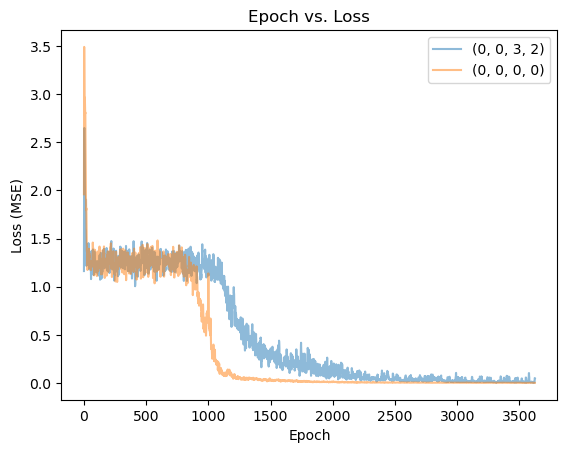

In [28]:
plot_loss(all_losses, size=4)

The LSTM does well with interleaved, reversed data (still need to check for harder formats). Able to achieve close to perfect accuracy on unseen tuples for all carry tables, seems like standard table loss converges more quickly than alternatives but want more robust data.

### Transformer

In [ ]:
b = 4
depth = 2
batch_size = 16

In [ ]:
# get carry tables for base
with open('../pickles/all_tables.pickle', 'rb') as f:
    all_tables = pickle.load(f)
tables = all_tables[b]

In [ ]:
table = tables[((0, 0, 0, 0), (0, 1, 2, 3), (0, 2, 0, 2), (0, 3, 2, 1))]

In [ ]:
# get dataloaders
training_dataloader, testing_dataloader = prepare_data(b, depth, table, batch_size=batch_size, num_passes=2000)

# initialize model
model = TransformerModel(b, 2, 2)

# define criterion and optimizer
criterion = Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# initialize variables
losses = []
t = 0

# training loop
for (X, s, ids) in training_dataloader:
    
    # compute, store, and print loss
    loss = criterion(model(X), s.float(), ids)
    losses.append(loss.item())
    if (t % 100 == 0):
        print(f't = {t}  loss = {loss.item():.6f}')
    
    # zero gradients, perform a backward pass, and update the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # iterate counter
    t += 1

In [ ]:
# test model
test(model, testing_dataloader, depth, batch_size, print_accuracy=True)